## 1. Creating Embeddings

In [3]:
import csv
import umap.umap_ as umap
from scipy import spatial
from sklearn.preprocessing import StandardScaler

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from requests.exceptions import HTTPError, ConnectionError, Timeout
from openai import OpenAI
import tiktoken
from itertools import islice
import numpy as np
from tenacity import retry, stop_after_attempt, wait_fixed, retry_if_exception_type

In [1]:
import requests
from bs4 import BeautifulSoup

# URL of the page
url = "https://www.paulgraham.com/articles.html"

# Fetch the content of the page
response = requests.get(url)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find all links to blog posts
# Assuming the blog post links are in <a> tags within <td> tags
links = soup.find_all('a', href=True)

# Extract and print the URLs
blog_post_urls = []
for link in links:
    href = link['href']
    # Check if the link is a relative URL, then prepend the base URL
    if not href.startswith('http'):
        href = url.rsplit('/', 1)[0] + '/' + href
    blog_post_urls.append(href)

# Print the blog post URLs
for post_url in blog_post_urls:
    print(post_url)


https://www.paulgraham.com/index.html
https://www.paulgraham.com/wisdom.html
https://www.paulgraham.com/kids.html
https://www.paulgraham.com/selfindulgence.html
https://www.paulgraham.com/reddits.html
https://www.paulgraham.com/google.html
https://www.paulgraham.com/best.html
https://www.paulgraham.com/superlinear.html
https://www.paulgraham.com/greatwork.html
https://www.paulgraham.com/getideas.html
https://www.paulgraham.com/read.html
https://www.paulgraham.com/want.html
https://www.paulgraham.com/alien.html
https://www.paulgraham.com/users.html
https://www.paulgraham.com/heresy.html
https://www.paulgraham.com/words.html
https://www.paulgraham.com/goodtaste.html
https://www.paulgraham.com/smart.html
https://www.paulgraham.com/weird.html
https://www.paulgraham.com/hwh.html
https://www.paulgraham.com/own.html
https://www.paulgraham.com/fn.html
https://www.paulgraham.com/newideas.html
https://www.paulgraham.com/nft.html
https://www.paulgraham.com/real.html
https://www.paulgraham.com/ric

In [4]:
# EMBEDDING A LINK

# Get num tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Set up OpenAI
client = OpenAI()

EMBEDDING_MODEL = 'text-embedding-3-small'
EMBEDDING_CTX_LENGTH = 8191
EMBEDDING_ENCODING = 'cl100k_base'

# Do embeddings with batching

# Vanilla embedding function
def get_embedding(text_or_tokens, model=EMBEDDING_MODEL):
    response = client.embeddings.create(input=text_or_tokens, model=model)
    return response.data[0].embedding

# Breaks up a sequence into chunks
def batched(iterable, n):
    """Batch data into tuples of length n. The last batch may be shorter."""
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while (batch := tuple(islice(it, n))):
        yield batch

# Encodes string into tokens, break into tokens
def chunked_tokens(text, encoding_name, chunk_length):
    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(text)
    chunks_iterator = batched(tokens, chunk_length)
    yield from chunks_iterator

# Get safe embedding
def len_safe_get_embedding(text, model=EMBEDDING_MODEL, max_tokens=EMBEDDING_CTX_LENGTH, encoding_name=EMBEDDING_ENCODING, average=True):
    chunk_embeddings = []
    chunk_lens = []
    for chunk in chunked_tokens(text, encoding_name=encoding_name, chunk_length=max_tokens):
        chunk_embeddings.append(get_embedding(chunk, model=model))
        chunk_lens.append(len(chunk))

    if average:
        chunk_embeddings = np.average(chunk_embeddings, axis=0, weights=chunk_lens)
        chunk_embeddings = chunk_embeddings / np.linalg.norm(chunk_embeddings)  # normalizes length to 1
        chunk_embeddings = chunk_embeddings.tolist()
    return chunk_embeddings

In [8]:
# EMBEDDING A USER ------------------------------------------------------

@retry(stop=stop_after_attempt(5), wait=wait_fixed(2), retry=retry_if_exception_type((ConnectionError, Timeout)))
def robust_get(url):
    return requests.get(url)

def process_link(url):
    try:
        link_response = robust_get(url)
        if link_response.status_code == 200:
            html = link_response.text
            soup = BeautifulSoup(html, 'html.parser')
            text = ' '.join(soup.stripped_strings)
            if text:
                return len_safe_get_embedding(text, model="text-embedding-3-small")
    except Exception as e:
        print(f"Failed to process URL {url}: {e}")
    return None

def fetch_and_process_pages(links):
    embeddings_list = []
    for url in links:
        print(f"Processing URL: {url}")
        embedding = process_link(url)
        if embedding is not None:
            embeddings_list.append(embedding)
    if not embeddings_list:
        return None
    embeddings_array = np.array(embeddings_list)
    # average_embedding = np.mean(embeddings_array, axis=0)
    # normalized_average_embedding = average_embedding / np.linalg.norm(average_embedding)
    return embeddings_array

In [9]:
# Create a dictionary to store embeddings for each person
person_embeddings = {}
person_embeddings['Em Herrera'] = fetch_and_process_pages("https://curius.app/api/users/2414/links")
person_embeddings['Tianyu Fang'] = fetch_and_process_pages("https://curius.app/api/users/1896/links")
person_embeddings['Sara Du'] = fetch_and_process_pages("https://curius.app/api/users/2020/links")
person_embeddings['Isabelle Levent'] = fetch_and_process_pages("https://curius.app/api/users/2332/links")
person_embeddings['Kevin Liu'] = fetch_and_process_pages("https://curius.app/api/users/2175/links")
person_embeddings['Kaylee George'] = fetch_and_process_pages("https://curius.app/api/users/1673/links")



Processing URL: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5859693
Processing URL: https://juliecare.co
Processing URL: https://www.youtube.com/watch?v=_WjUFuW2J0A
Processing URL: https://www.jeremyforlabour.com/digital_democracy_manifesto
Processing URL: https://www.wired.com/2008/06/scenius-or-comm
Processing URL: https://every.to/cybernaut/the-quest-for-a-dumber-phone
Processing URL: https://onezero.medium.com/the-psychology-of-tiktok-f10bc1506f1a
Processing URL: https://reader.elsevier.com/reader/sd/pii/S0160791X21002530?token=1BAEC71CC1BA387830F744A7B789584BAB6E63A5E23865124591E44966A6D5891132759BA0B4929EA7BEE52068440999
Failed to process URL https://reader.elsevier.com/reader/sd/pii/S0160791X21002530?token=1BAEC71CC1BA387830F744A7B789584BAB6E63A5E23865124591E44966A6D5891132759BA0B4929EA7BEE52068440999: RetryError[<Future at 0x2df1d9f50 state=finished raised SSLError>]
Processing URL: https://www.fastcompany.com/1809674/return-livejournal
Processing URL: https://medium.com/@lynn

## 2. Creating Visualization

In [12]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
reducer = umap.UMAP()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
reduced_data = reducer.fit_transform(scaled_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [13]:
import matplotlib.pyplot as plt

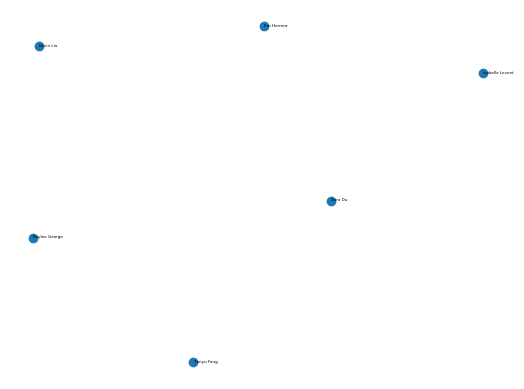

In [14]:
# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="3")

# Clean-up and Export
plt.axis('off')
plt.savefig('visualization.png', dpi=800)


## 3. [BONUS] Providing top matches

In [ ]:
from collections import defaultdict

In [ ]:
top_matches = {}
all_personal_pairs = defaultdict(list)
for person in attendees_map.values():
    for person1 in attendees_map.values():
        all_personal_pairs[person].append([spatial.distance.cosine(person_embeddings[person1], person_embeddings[person]), person1])

for person in attendees_map.values():
    top_matches[person] = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:6] # drop yourself, take top 5

print(top_matches)
